## Testing the Variogram methods

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib ipympl
%matplotlib inline

from variogram.Variogram import Variogram
from variogram.VisualizeVariogram import VisualizeVariogram
from Dataset import DatasetName, load_dataset, load_single_file
from data_preprocessing import plot_buoy_data_time_collapsed, plot_buoy_data_at_time_step

import geostatspy.geostats as geostats
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from datetime import datetime, timedelta
from ipywidgets import interact, interactive, IntSlider
import numpy as np
import os

dataset_name = DatasetName.AREA4
# data = load_single_file(dataset_name, file_idx=0) # 8000 pts
data = load_dataset(dataset_name, overlap=False)    # 300,000 pts

# convert time axis to datetime
data["time"] = pd.to_datetime(data["time"])

# find earliest time/date and subtract from time column
earliest_date = data["time"].min()
data["time_offset"] = data["time"].apply(lambda x: (x - earliest_date).seconds//3600 + (x-earliest_date).days*24)
data["time_offset"] = data["time_offset"].astype(int)

Loaded AREA4 dataset.

Buoy Meta Data:
    Min time: 2022-04-21 19:00:00, max time: 2022-05-25 18:00:00
    Min lon: -120.0, max lon: -100.0
    Min lat: -38.845, max lat: -20.605
    Number or rows: 18441.



## Visualise raw data spacially

27


IntSlider(value=0, description='Time [hrs]:', max=214)

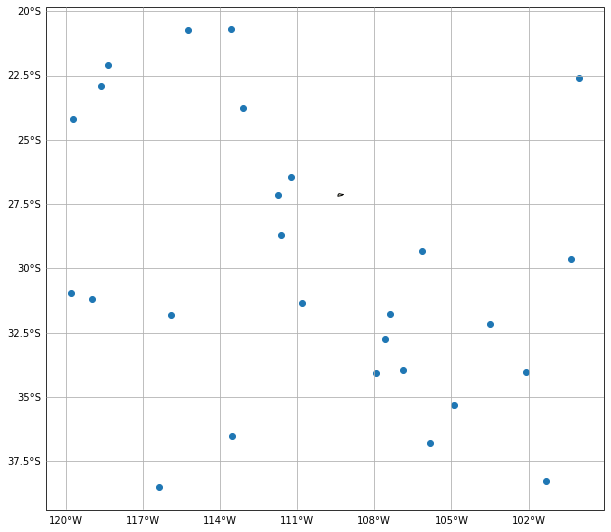

In [37]:
# visualise raw data
fig, scatter, ax = plot_buoy_data_at_time_step(data)

# Try with matplotlib
time_list = sorted(list(set(data["time_offset"].astype(int).tolist())))

time = widgets.IntSlider(
    value=0,
    min=0,
    max=time_list[-1],
    step=1,
    description="Time [hrs]:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal"
)

def update(time):
    scatter.set_ydata(data[data["time_offset"] == time]["lat"])
    scatter.set_xdata(data[data["time_offset"] == time]["lon"])
    fig.canvas.draw_idle()

w = widgets.interactive(update, time=time)
display(time)

## Compute and plot variogram

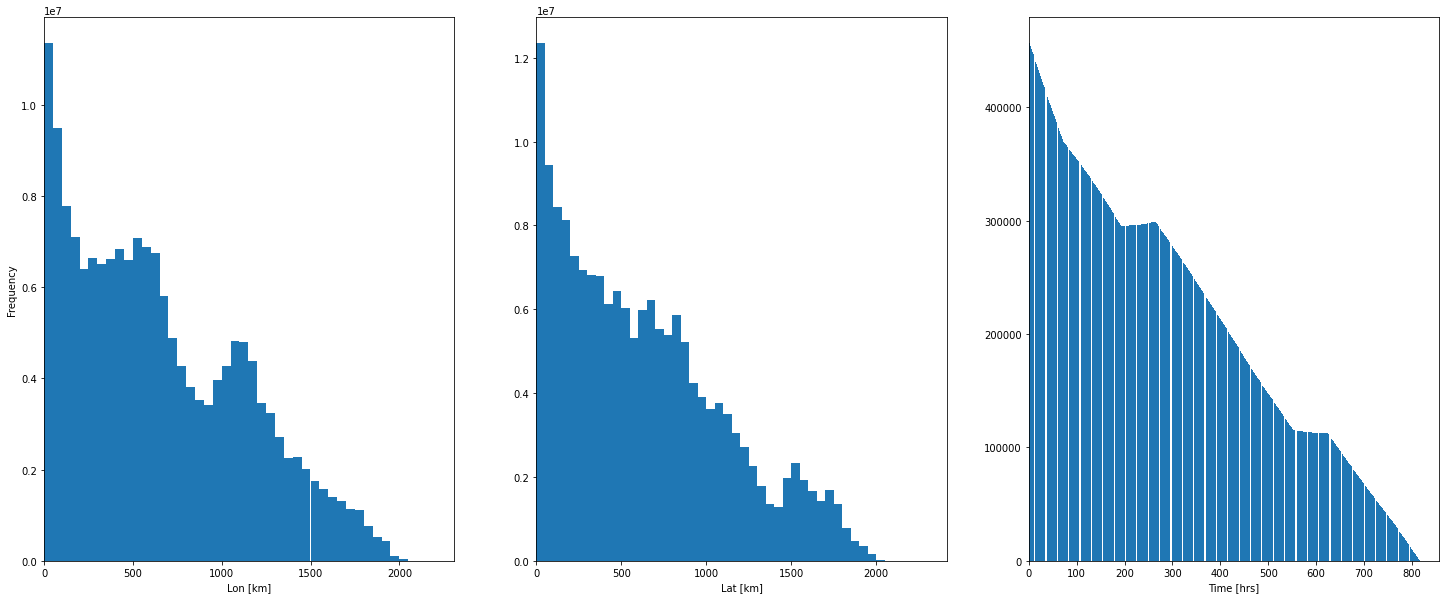

In [3]:
# Variogram calculation -> for cmd line runnable script see compute_variogram.py
V = Variogram(data)
V.detrend(detrend_var="lat", num_bins=1)
bins, bins_count = V.build_variogram_gen((50,50,1), num_workers=4, chunk_size=int(1e6),\
    detrended=True, cross_buoy_pairs_only=False, units="km")
Vvis = VisualizeVariogram(V)
Vvis.plot_histograms()

## Use new VisualizeVariogram class (which support loading from file and decreasing resolution)

In [4]:
# reading from file
Vvis = VisualizeVariogram()
Vvis.read_variogram_from_file()

Loaded variogram from: AREA1_5.0_5.0_1.0_True_False_True.npy.
Resolution: [5.0, 5.0, 1.0] km.
Number of pairs: 15014161134.


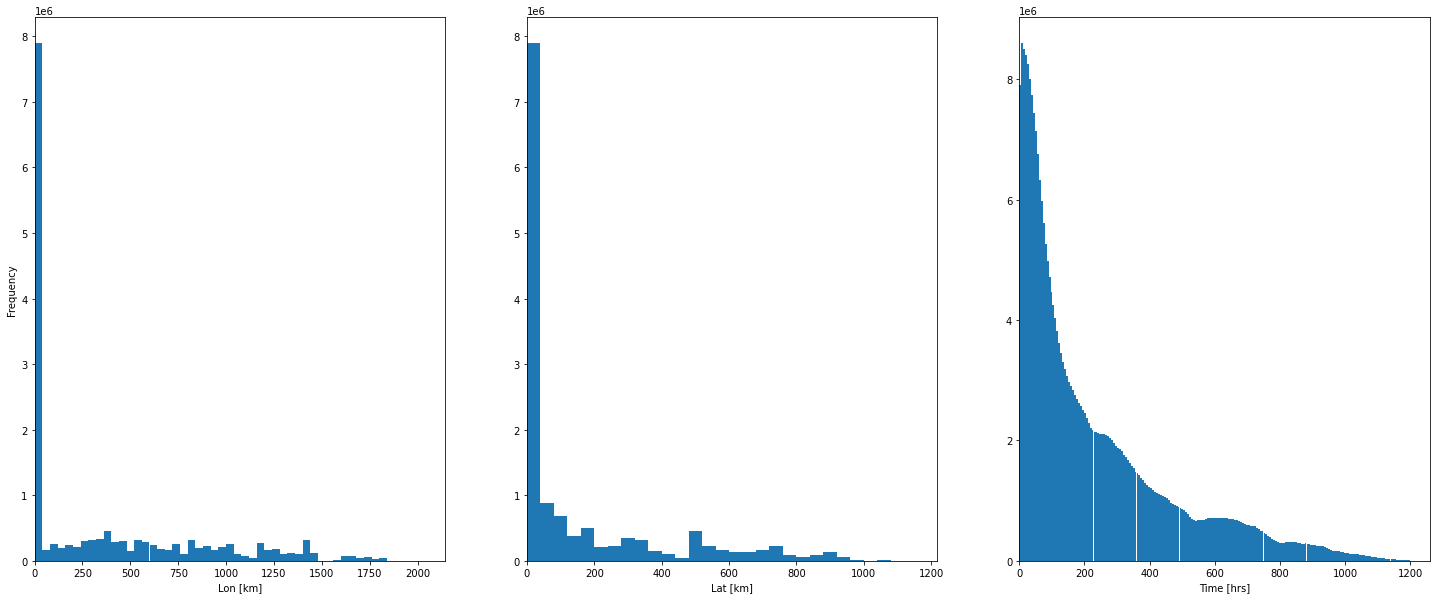

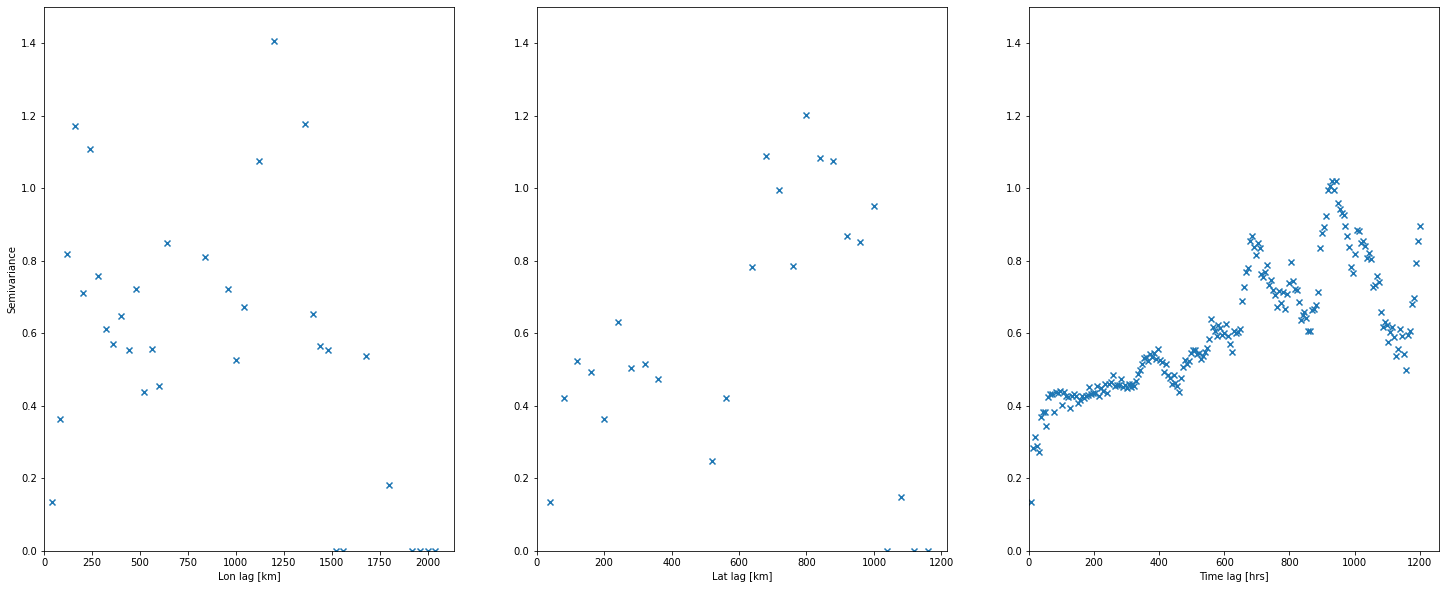

In [6]:
# visualizing at different resolutions and different slicing tolerances
Vvis.decrease_variogram_res((40,40,6))
slicing_tol = [1, 1, 1]
view_range = [80,40,200]
Vvis.plot_histograms(tol=slicing_tol, view_range=view_range)
Vvis.plot_variograms(variable="u", tol=slicing_tol, view_range=view_range)

In [11]:
# convert variogram to dataframe and save
variogram_dims = Vvis.variogram.bins.shape[:3]
lon_lag, lat_lag, time_lag = [], [], []
u_semivariance, v_semivariance = [], []
for lon in range(variogram_dims[0]):
    for lat in range(variogram_dims[1]):
        for time in range(variogram_dims[2]):
            u_semivariance.append(Vvis.variogram.bins[lon, lat, time,0])
            v_semivariance.append(Vvis.variogram.bins[lon, lat, time,1])
            lon_lag.append((lon+1)*Vvis.variogram.lon_res)
            lat_lag.append((lat+1)*Vvis.variogram.lat_res)
            time_lag.append((time+1)*Vvis.variogram.t_res)

df = pd.DataFrame({"lon_lag":lon_lag, "lat_lag":lat_lag, "time_lag":time_lag, "u_semivariance":u_semivariance, "v_semivariance":v_semivariance})
file_path = "/home/jonas/Downloads/big_variogram.csv"
df.to_csv(file_path, index=False)

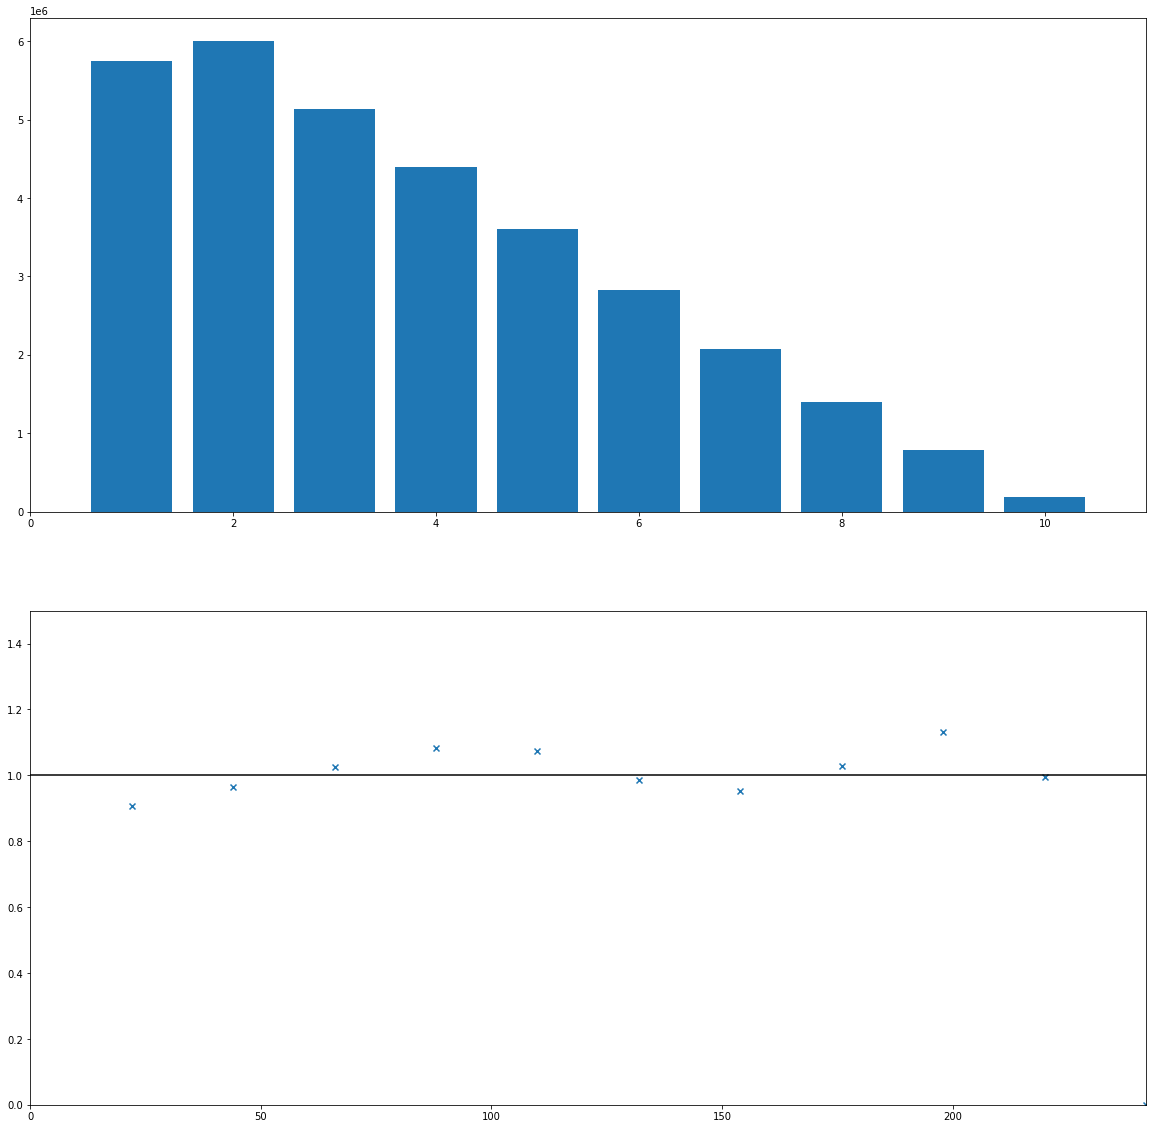

In [85]:
# plot combined histogram by taking euclidean distance to compute lag scalar
total_bins_count = V.total_bins_count
total_bins = V.total_bins
total_res = V.total_res

cutoff = 11
error_var = 0

fig, axs = plt.subplots(2,1, figsize=(20,20))
axs[0].bar(np.arange(len(total_bins_count[:cutoff,0]))+1, total_bins_count[:cutoff,error_var])
axs[0].set_xlim((0,len(total_bins[:cutoff])))
axs[1].scatter(total_res*(np.arange(len(total_bins_count[:cutoff,0]))+1), total_bins[:cutoff,error_var], marker="x")
axs[1].set_xlim((0,len(total_bins[:cutoff])*total_res))
axs[1].plot(total_res*np.arange(len(total_bins[:cutoff])+1), np.full(len(total_bins[:cutoff])+1, 1), color="k")
axs[1].set_ylim([0,1.5])
plt.show()

# export data for fitting test
x = total_res*(np.arange(len(total_bins_count[:cutoff,0]))+1)
y = total_bins[:cutoff,0]
variogram_pts = pd.DataFrame({"lag":x, "semivariance":y})
variogram_pts.to_csv("/home/jonas/Downloads/variogram_pts.csv", index_label=False)

## Scikit-GStat package

loaded: copernicus_forecast_error_lon_[-140, -120]_lat_[20.0, 30.0]_time_2022-05-22T18:30:00Z__2022-05-31T17:30:00Z.csv


/home/jonas/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


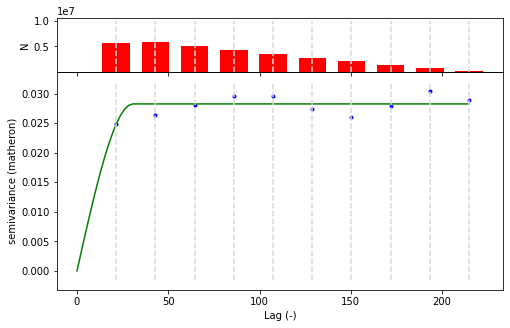

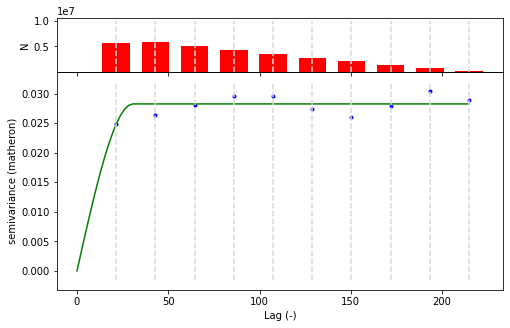

In [73]:
# use existing SciKit-GStat package
from Dataset import load_single_file, DatasetName
import skgstat as skg

dataset_name = DatasetName.AREA1
data = load_single_file(dataset_name, file_idx=0)

# convert time axis to datetime
data["time"] = pd.to_datetime(data["time"])

# find earliest time/date and subtract from time column
earliest_date = data["time"].min()
data["time_offset"] = data["time"].apply(lambda x: (x - earliest_date).seconds//3600 + (x-earliest_date).days*24)

coordinates = np.hstack([np.array(data["time_offset"]).reshape(-1,1), np.array(data["lon"]).reshape(-1,1), np.array(data["lat"]).reshape(-1,1)])
values = np.array([data["u_error"]]).reshape(-1)

# the SpaceTimeVariogram to work we need values of (m, n) with m being the coordinates dimension and n the time dimension
V = skg.Variogram(coordinates, values, dist_func="euclidean", bin_func="even", n_lags=10)
V.plot()
# print(V.bins, V.experimental, V.data)

## Sanity Check to Verify VariogramAnalysis class works

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
lon_lag_km_bins: [11  3  6 15  5  9]
lat_lag_km_bins: [ 5  6  1 12  4  8]


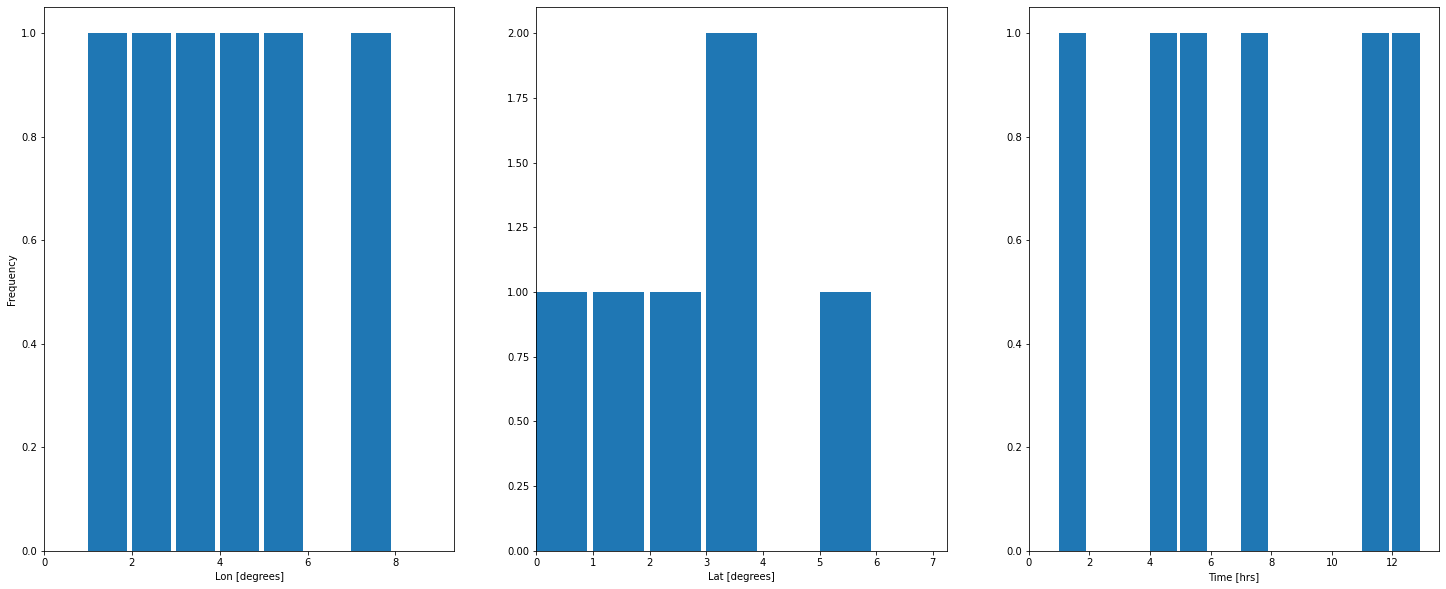

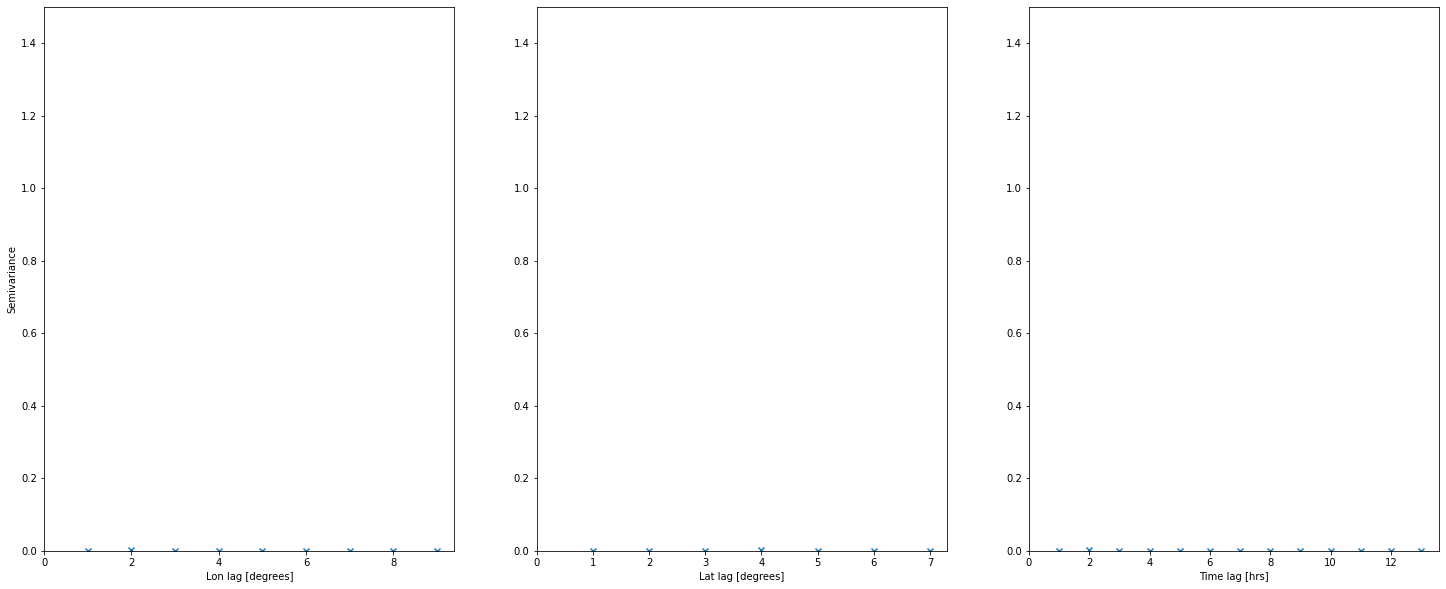

In [70]:
%load_ext autoreload
%autoreload 2

# Note for easier analysis comment out the division at the end of the function

from ocean_navigation_simulator.generative_error_model.variogram.Variogram import Variogram, convert_degree_to_km
from variogram.VisualizeVariogram import VisualizeVariogram

from datetime import datetime
import pandas as pd

# define toy values for all cols
time = np.array([datetime(2022,5,5,13), datetime(2022,5,6,1), datetime(2022,5,5,14), datetime(2022,5,5,18)])
# t_lag = [12, 1, 5, 11, 7, 4]
lon = np.array([-130.5, -124.6, -132.1, -127.3])
# lon_lag = [5, 1, 3, 7, 2, 4]
lat = np.array([25.2, 27.6, 22.1, 25.8])
# lat_lag = [2, 3, 0, 5, 1, 3]
u_error = np.array([0.3, 0.5, 0.7, 0.5])
# u_squared_diff = [0.02, 0.08, 0.02, 0.02, 0.0, 0.02]
v_error = np.array([0.3, 0.7, 0.5, 0.5])
# v_squared_diff = [0.16, 0.04, 0.04, 0.04, 0.4, 0.0]
buoy = np.array(["1", "2", "3", "1"])

idx_i = np.array([0,0,0,1,1,2])
idx_j = np.array([1,2,3,2,3,3])
pts1 = np.hstack((lon[idx_i].reshape(-1,1), lat[idx_i].reshape(-1,1)))
pts2 = np.hstack((lon[idx_j].reshape(-1,1), lat[idx_j].reshape(-1,1)))
lon_lag, lat_lag = convert_degree_to_km(pts1, pts2)
print(f"lon_lag_km_bins: {np.floor(np.absolute(lon_lag)/50).astype(int)}")
print(f"lat_lag_km_bins: {np.floor(np.absolute(lat_lag)/50).astype(int)}")

# create dataset
toy_example = {"time":time, "lon":lon, "lat":lat, "u_error":u_error, "v_error":v_error, "buoy":buoy}
data = pd.DataFrame(toy_example)

vario_ana = Variogram(data)
vario_ana.build_variogram_gen((1,1,1), 1, chunk_size=3, detrended=False, cross_buoy_pairs_only=False, units="degrees")
Vvis = VisualizeVariogram(variogram=vario_ana)
Vvis.plot_histograms()
Vvis.plot_variograms("u")

## Exploring detrending

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


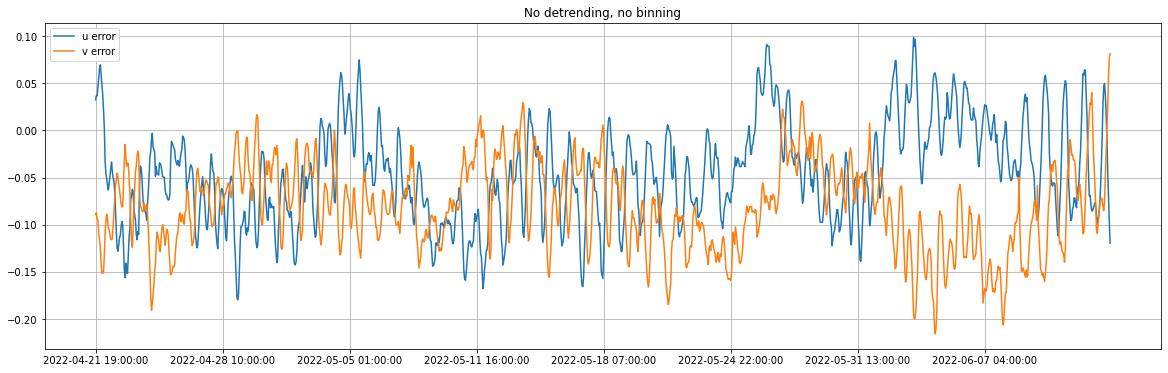

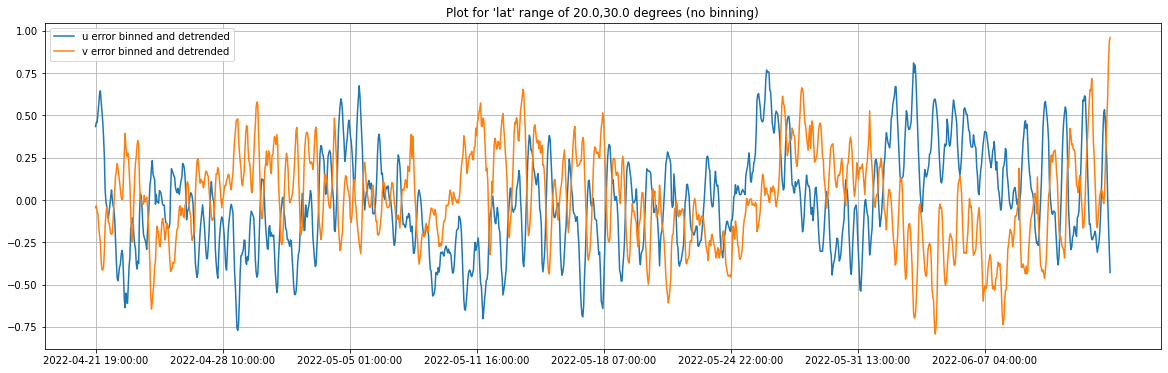

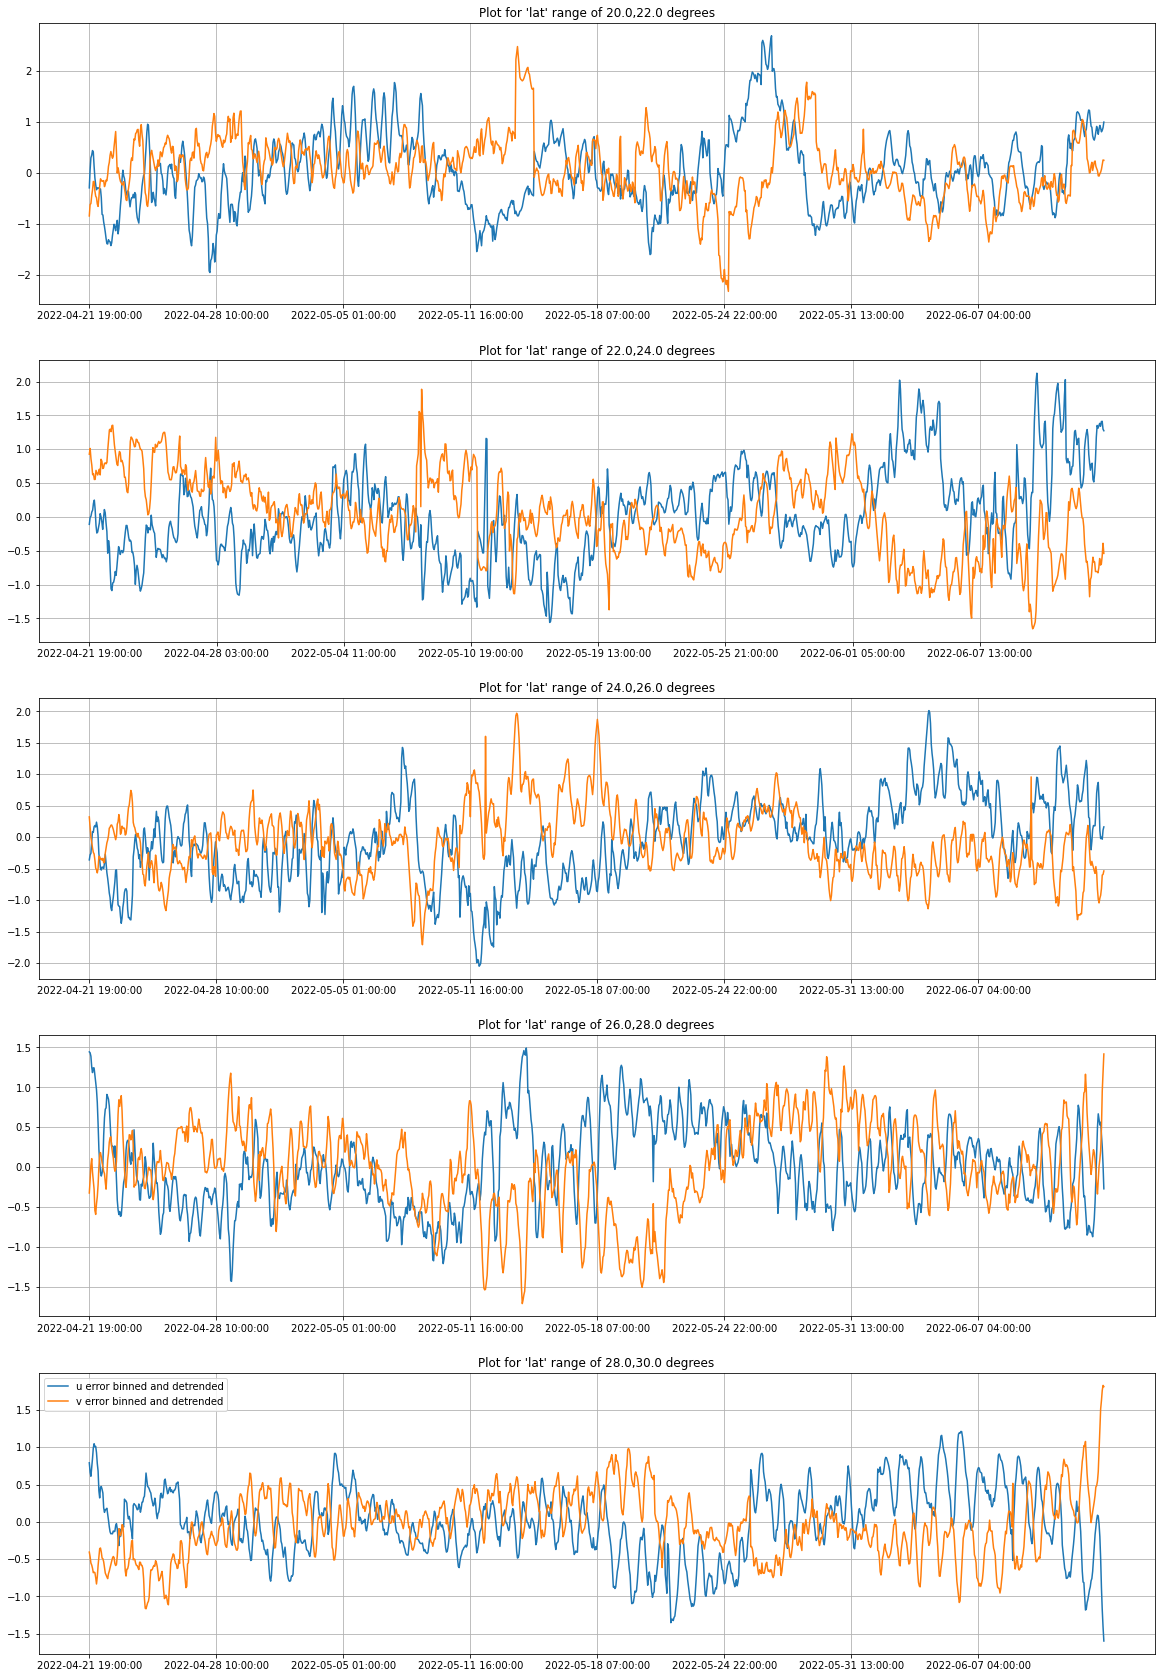

In [86]:
%load_ext autoreload
%autoreload 2

from generative_model_metrics import calc_speed_mean, calc_speed_RMSE
from variogram.VariogramAnalysis import VariogramAnalysis
from Dataset import load_dataset, DatasetName

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# load 40 days worth of data
dataset_name = DatasetName.AREA1
df = load_dataset(dataset_name)
var_ana = VariogramAnalysis(df)

# plotting RMSE without detrending and binning
df_group = df.groupby(by=["time"], as_index=False).mean()
fig, ax = plt.subplots(figsize=(20,6))
# plt.plot(df_group["time"], df_group["RMSE"], label="RMSE")
plt.plot(df_group["time"], df_group["u_error"], label="u error")
plt.plot(df_group["time"], df_group["v_error"], label="v error")
plt.xticks(np.arange(0, len(df_group), round(len(df_group)/8)))
plt.title("No detrending, no binning")
plt.legend()
plt.grid()
plt.show()

# detrended without binning
var_ana.detrend(detrend_var="lat", num_bins=1)
var_ana.plot_detrended_bins()

# detrended with binning
var_ana.detrend(detrend_var="lat", num_bins=5)
var_ana.plot_detrended_bins()

## Plot bin stats over different axes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


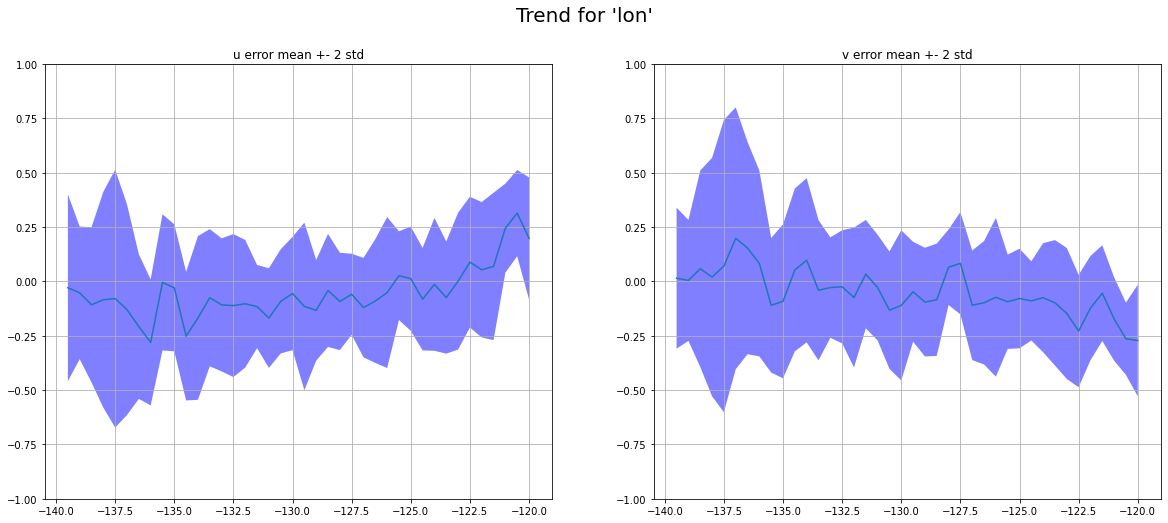

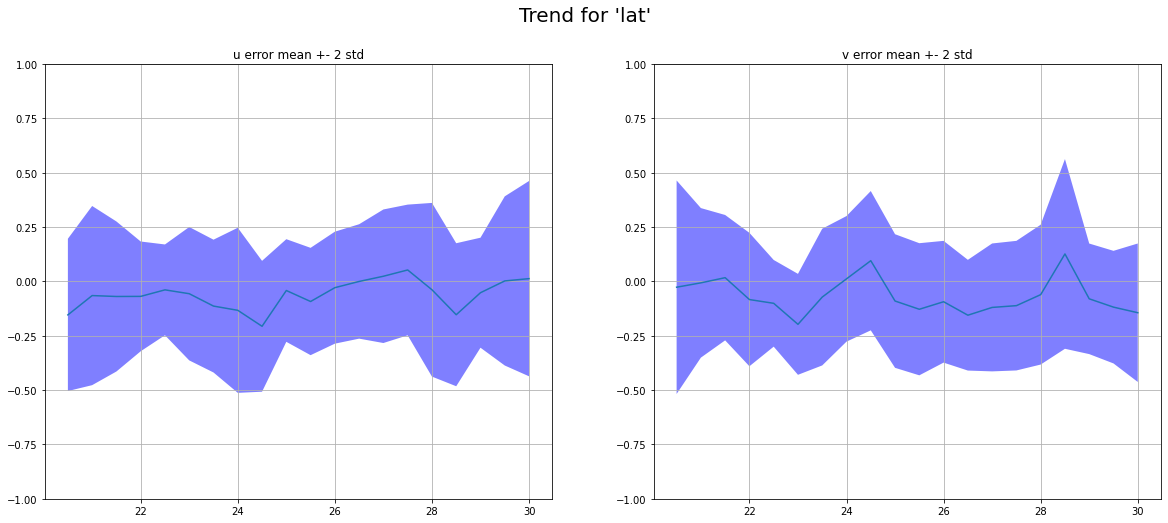

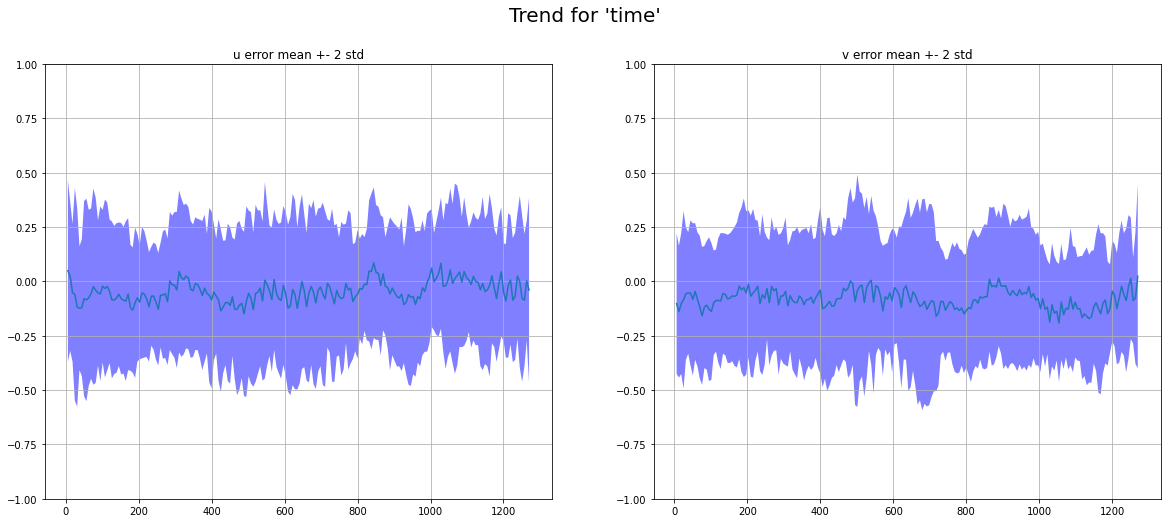

In [91]:
%load_ext autoreload
%autoreload 2

from Dataset import load_single_file, DatasetName, load_dataset
from variogram.VariogramAnalysis import VariogramAnalysis

dataset_name = DatasetName.AREA1
data = load_dataset(dataset_name)

V = VariogramAnalysis(data)

V.plot_bin_stats(detrend_var="lon", num_bins=40)
V.plot_bin_stats(detrend_var="lat", num_bins=20)
V.plot_bin_stats(detrend_var="time", num_bins=200)

## Detrending Plots in 3D

 - still bin data by e.g. `lat`
 - no group by time to produce -> group by [`lon`, `lat`]

In [ ]:
%load_ext autoreload
%autoreload 2

from generative_model_metrics import calc_speed_mean, calc_speed_RMSE
from variogram.VariogramAnalysis import VariogramAnalysis
from Dataset import load_test_data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# load 40 days worth of data
df = load_test_data()

lon = np.arange(20)
lat = np.arange(10)
# use meshgrid to define domain
lonv, latv = np.meshgrid(lon, lat)

# TODO: visualise in 3D by summing over time

This looks very similar to the shape produced by the 1D variogram produced with my own code!

# Using Geostatspy for 2D

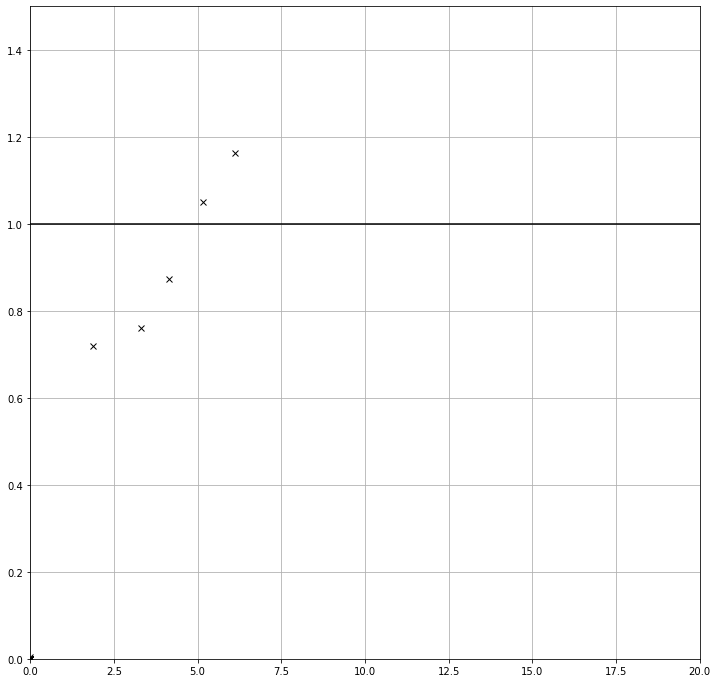

In [20]:
# set params
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 2.0; lag_tol = 4.0; nlag = 20;               # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 22.5                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [0, 90]                                       # directions in azimuth to consider

lag, gamma, npp = geostats.gamv(
    data,
    "lon",
    "lat",
    "u_error",
    tmin,
    tmax,
    lag_dist,
    lag_tol,
    nlag,
    azi_mat[0],
    atol,
    bandh,
    isill
)

fig = plt.figure(figsize=(12,12))
plt.plot(lag, gamma, 'x', color = 'black')
plt.plot([0,20], [1.0, 1.0], color = 'black')
plt.xlim([0, 20])
plt.ylim([0, 1.5])
plt.grid(True)
plt.show()